In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('scrape.csv',index_col='date',parse_dates=True)
data.head()

,rupee
date,
2016-01-04,66.5277
2016-01-05,66.5471
2016-01-06,66.7124
2016-01-07,66.7392
2016-01-08,66.8250


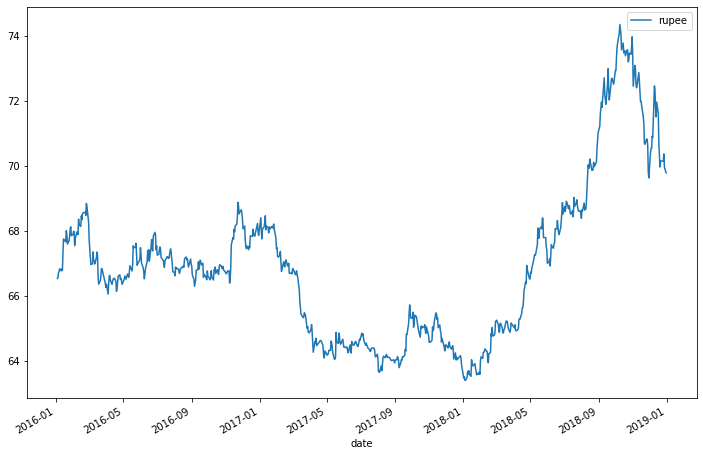

In [3]:
data.plot(figsize=(12,8))

In [71]:
test_size=30
train_index=len(data)-test_size
train=data.iloc[:train_index]
test=data.iloc[train_index:]

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range = (0,1))
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [73]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 15
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length, n_features)))
model.add(Dropout(0.2))

model.add(Dense(1))

opt=Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse')

In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [76]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

x,y=validation_generator[0]
print(x,y)

[[[0.75068493]
  [0.74063927]
  [0.72283105]
  [0.66666667]
  [0.66347032]
  [0.67853881]
  [0.67762557]
  [0.66027397]
  [0.58630137]
  [0.56894977]
  [0.64018265]
  [0.65205479]
  [0.65205479]
  [0.68630137]
  [0.68219178]]] [[0.82744292]]


In [77]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [78]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0267 - val_loss: 0.0082
Epoch 2/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 3/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0031 - val_loss: 0.0100
Epoch 4/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 5/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 6/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 7/20
714/714 [==============================] - 16s 23ms/step - loss: 0.0026 - val_loss: 0.0070
Epoch 8/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 9/20
714/714 [==============================] - 16s 22ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 10/20
714/714 [==============================] - 16s 22ms/step - loss: 0.002

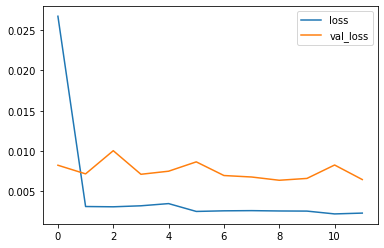

In [79]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [80]:
train_predictions=[]

first_eval_batch = scaled_train[:length]
train_predictions=list(first_eval_batch)
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(train)-length):
    current_pred = model.predict(current_batch)[0]
    train_predictions.append(current_pred) 
    print(current_pred,scaled_train[i])
    current_batch = np.append(current_batch[:,1:,:],[[scaled_train[i+length]]],axis=1)
    

[0.38806087] [0.28654795]
[0.39136797] [0.28831963]
[0.39415085] [0.30341553]
[0.39850575] [0.30586301]
[0.4035393] [0.31369863]
[0.40533406] [0.308]
[0.4064242] [0.31385388]
[0.40814433] [0.30882192]
[0.40867344] [0.36037443]
[0.40315157] [0.39771689]
[0.39961553] [0.39184475]
[0.398808] [0.38945205]
[0.3985768] [0.42103196]
[0.3984502] [0.40812785]
[0.4051925] [0.38322374]
[0.41125694] [0.39321461]
[0.41657385] [0.40552511]
[0.42579865] [0.42611872]
[0.432487] [0.43171689]
[0.43988442] [0.40705936]
[0.44688332] [0.4096347]
[0.45244196] [0.41871233]
[0.45704374] [0.41854795]
[0.45888013] [0.37899543]
[0.4643869] [0.39838356]
[0.4686553] [0.41712329]
[0.46544832] [0.41441096]
[0.4531232] [0.40972603]
[0.4343209] [0.45322374]
[0.41016266] [0.43715068]
[0.3833917] [0.43287671]
[0.35890552] [0.46208219]
[0.3435326] [0.45194521]
[0.3306058] [0.46863014]
[0.32199273] [0.47077626]
[0.31629074] [0.4723105]
[0.3162946] [0.47237443]
[0.3213923] [0.46385388]
[0.32690647] [0.497379]
[0.32466274] 

In [91]:
test_predictions=[]

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

cnt=0
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    print(current_pred,scaled_train[i])
    current_batch = np.append(current_batch[:,1:,:],[[scaled_test[i]]],axis=1)
    

[0.79739136] [0.28654795]
[0.7780811] [0.28831963]
[0.75904197] [0.30341553]
[0.7408899] [0.30586301]
[0.7172634] [0.31369863]
[0.6934319] [0.308]
[0.67536235] [0.31385388]
[0.6622097] [0.30882192]
[0.65097976] [0.36037443]
[0.6320155] [0.39771689]
[0.61286765] [0.39184475]
[0.6062978] [0.38945205]
[0.602983] [0.42103196]
[0.6037851] [0.40812785]
[0.61506134] [0.38322374]
[0.6312749] [0.39321461]
[0.66507816] [0.40552511]
[0.69383305] [0.42611872]
[0.71006286] [0.43171689]
[0.7165631] [0.40705936]
[0.7250351] [0.4096347]
[0.7281669] [0.41871233]
[0.7150428] [0.41854795]
[0.6937717] [0.37899543]
[0.66460973] [0.39838356]
[0.6381775] [0.41712329]
[0.6148527] [0.41441096]
[0.59847546] [0.40972603]
[0.5927246] [0.45322374]
[0.58777964] [0.43715068]


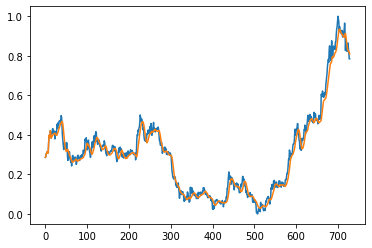

In [82]:
import matplotlib.pyplot as plt
plt.plot(scaled_train)
plt.plot(train_predictions)

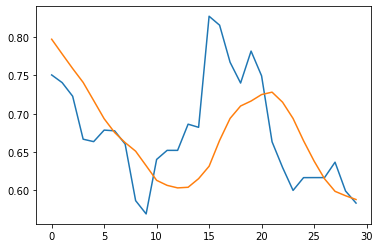

In [92]:
import matplotlib.pyplot as plt
plt.plot(scaled_test)
plt.plot(test_predictions)

In [95]:
true_predictions = scaler.inverse_transform(test_predictions)
test['predictions']=true_predictions

test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rupee,predictions
date,,
2018-11-19,71.6100,72.121435
2018-11-20,71.5000,71.909988
2018-11-21,71.3050,71.701510
2018-11-22,70.6900,71.502744
2018-11-23,70.6550,71.244034
2018-11-26,70.8200,70.983079
2018-11-27,70.8100,70.785218
2018-11-28,70.6200,70.641196
2018-11-29,69.8100,70.518228


In [96]:
loss1=model.evaluate(generator)
loss2=model.evaluate(validation_generator)
print(loss1,loss2)

15/15 [==============================] - 0s 3ms/step - loss: 0.0065
0.0011103140423074365 0.006466763559728861
